# PROJECT PREREQUISITES

## Installing and Importing Dependencies

In [1]:
%pip install gymnasium 
%pip install matplotlib
%pip install pygame
%pip install tqdm
%pip install moviepy

import numpy as np
import gymnasium as gym
from gym.wrappers import RecordVideo
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import random
import math
from IPython.display import Video

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# PROJECT INFORMATION

## The Cart Pole
The cart pole  consists of a cart that can move linearly and a rotating pole attached to it via a bearing
## The Objective

<div>
<img src="./assets/images/problem_diagram.png" width="500"/>
</div>

The control objective is to keep the pole in the verical position by applying horizontal actions to the cart. The set of actions one can perform are:
1. Pushing the cart left
2. Pushing the cart right

The variables which determine what actions to take depend on
* Cart Position (-4.8 to 4.8)
* Cart Velocity (-∞ to ∞)
* Pole angle of rotation (-24 degrees to 24 degrees)
* Pole angular velocity (-∞ to ∞)

An episode terminates when:
1. The Pole angle becomes greater than ± 12 degrees
2. Cart position is greater than ± 2.4
3. Episode length is greater than 500

## Task
1. Development of the RL agent. Demostrate the correctness of the implementation by sampling a random state form the cart pole environment, inputting to the agent and outputting a chosen action. Print the values of the state and chosen action in Jupyter notebook. [30 marks] 

2. Demonstrate the effectiveness of the RL agent. Run for 100 episodes and plot the cumulative reward against all episodes in Juptyer. Print the averagee reward over the 100 episodes. The average reward should be larget than 195. [40 marks] 

3. Render one episode played by the developed RL agent on Jupyter. (refer to lab assignment for rendering code link) [10 marks] 

4. Format the Jupter notebook by including step-by-step instruction and explanation, such that the notebook is easy to follow and run. Include text explanation to demonstrate the originality  of your implementation and your understanding of the code. [20 marks]

# CONCEPTS

## Discretising the statespace

The state space for our Cart Pole system is not discrete. The state of *(θ, ω, x, v)* is continuous, which mean that we have an infinite number of action-value functions. Hence, we want to approximate a continuous state-space by a finite discrete state-space.

To achieve this, we can divide the state into a number of segments and the assign each continuous state vector to a set of discrete indices. This process produces a Q-matrix.

<div>
<img src="./assets/images/Q-table_with_discretisation.png" width="400"/>
</div>

By using the Q-table we can run the algorithm. First, we observe the state S, then, we discretize this state, to obtain discrete indices ($ I_{x},I_{v},I_{\theta},I_{w} $). Then, we can use these discrete indices to select a row of the Q-table, that represents the action value function values for certain actions. By using this type of discretization and indexing we can run the Q-learning algorithm.

## Epsilon-Greedy Algorithm

Here's the epsilon-greedy algorithm with a more mathematical twist:

At each decision step:

1. **Exploration vs Exploitation:**
   - Generate a random number *u* uniformly distributed between 0 and 1.

2. **Exploration (with probability ε):**
   - If *u* ≤ ε:
      - Select an action *a* randomly from set *A*.

3. **Exploitation (with probability 1-ε):**
   - If *u* > ε:
      - Choose the action *a* with the highest estimated Q-value:
        *a = argmax(Q(a)) for all a ∈ A*

This translates to selecting an action based on a probability distribution:

**Action Selection Probability:**
  - P(choosing a) = (1 - ε) if Q(a) = max(Q(b)) for all b ∈ A
  - P(choosing a) = ε / |A| otherwise


## Q-learning Algorithm

For every time step of a single episode (until the terminal state is reached):

Step 1: Select action A in the state S with the epsilon-greedy algorithm. 

Step 2: Apply action A to the environment, and observe the reward R and the next state S'.

Step 3: Update the action value function: 

- If the next state S' is not the terminal state   
$$ \begin{align*}         Q(S,A)& \leftarrow Q(S,A) +\alpha \Big(R+\gamma Q_{\text{max}}-Q(S,A) \Big) \\Q_{\text{max}} & =\text{max}_{a} Q(S',a) \end{align*} $$


- If the next state S' is the terminal state  
$$ \begin{align*}         Q(S,A)& \leftarrow Q(S,A) +\alpha \Big(R-Q(S,A) \Big) \\\end{align*} $$


Step 4: Set S=S’ and start again from Step 1.

Once the algorithm is executed for a number of episodes, we compute the action value function Q(S,A). Then, we select the action A in state S simply as
   
$$\begin{align*}A(S)=\text{argmax}_{A}Q(S,A)\end{align*} $$

That is, we select the action A in a particular state that produces the maximal value of the action value function at that state


# TASK 1: DEVELOPMENT OF RL AGENT

In this code snippet, we'll test the functionality of a Reinforcement Learning (RL) agent trained for the CartPole environment. Here's how it works:

The code first grabs a random snapshot of the environment (the CartPole's state). This state includes information like the cart's position and velocity, as well as the angle and angular velocity of the pole itself.
This random state is then fed as input to the RL agent.
The agent, based on its training, should analyze the state and choose an action. This action typically involves pushing the cart left or right to keep the pole balanced.
Finally, the chosen action (e.g., 0 for left push, 1 for right push) is printed in a Jupyter notebook cell. This allows us to see what action the agent decided to take for the given state.

## The CartPole Environment

We create the environment instance for the 'CartPole-v1' problem using OpenAI Gym' toolkit in python

In [2]:
env = gym.make("CartPole-v1")

Printing the action space returns a value of Discrete(2). This is in reference to the two actions that we can take, 0(left) and 1(right). Printing the observation space returns the minimum and maximum values of our states. The 4 values correspond to the cart position, cart velocity, pole angle and pole angular velocity.

In [3]:
print(env.action_space)
print(env.observation_space)

Discrete(2)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


At the end of each round also known as an episode, the pole will be resetted to a random initial state that is close to [0,0,0,0]. 

In [4]:
print(env.reset())

(array([ 0.03362957, -0.02720089, -0.02773453,  0.03860779], dtype=float32), {})


The function env.step() returns variables about the environment based on the action as the argument. The values we are interested in are next state, reward and terminated. 
- next state: contains the information of the cart pole's state after performing the given action. This includes the details of cart position, cart velocity, pole angle and pole angular velocity.
- reward: the value of reward attained from taking that particular action
- terminated: a boolean flag on whether the cartpole has reached the termination conditions

In [5]:
next_state, reward, terminated, truncated, info = env.step(0)
print('The next state after performing action is: ', next_state)
print('the reward from this action is: ', reward)
print('Has this round terminated: ', terminated)

The next state after performing action is:  [ 0.03308555 -0.22191437 -0.02696238  0.3224128 ]
the reward from this action is:  1.0
Has this round terminated:  False


We now have sufficient knowledge to test out one episode. This is done via a naive strategy so the actions will be randomised. The cumulative reward after the episode termination will be returned at the end of the round. It is evident that this streategy is not optimal.

In [6]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    action = random.randint(0, 1)
    observation, reward, done, _, _ = env.step(action)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 14.0


Create another instance of the cartpole environment

In [7]:
env = gym.make('CartPole-v1')

## Discretisation

As previously mentioned, the possible statespace of the cartpole is continuous. Hence in order to make them finite, we have to discretise them into intervals. For the boundaries, we used analysed the probabilities of the cartpole landing in out-of-bound areas to decide on the boundary value.

We first declare the various upper and lower bounds for each of the state variables.

In [8]:
cart_position_lower_bound = env.observation_space.low[0] 
cart_veloctiy_lower_bound = -3
pole_angle_lower_bound = env.observation_space.low[2] 
pole_angular_velocity_lower_bound = -math.radians(45)

cart_position_upper_bound = env.observation_space.high[0] 
cart_velocity_upper_bound = 3
pole_angle_upper_bound = env.observation_space.high[2] 
pole_angular_velocity_upper_bound = math.radians(45) 

lower_bounds = [cart_position_lower_bound, cart_veloctiy_lower_bound, pole_angle_lower_bound, pole_angular_velocity_lower_bound]
upper_bounds = [cart_position_upper_bound, cart_velocity_upper_bound, pole_angle_upper_bound, pole_angular_velocity_upper_bound]

Next, we declared the number of bins. This numbers were derived based on analysis of the usage of the number of bins for its corresponding state types and the optimal set of values that produced the best results.

In [9]:
global num_bins

cart_position_number_of_bins = 1
cart_velocity_number_of_bins = 1
pole_angle_number_of_bins = 6
pole_angular_velocity_number_of_bins = 12

num_bins = (cart_position_number_of_bins, cart_velocity_number_of_bins, pole_angle_number_of_bins, pole_angular_velocity_number_of_bins)

We then use the numpy function linspace to return an array of evenly spaced intervals according to our number of bins of each type. We then store this value in a global bin tuple.

In [10]:
global bins

cart_position_bin = np.linspace(cart_position_lower_bound, cart_position_upper_bound, num_bins[0])
cart_velocity_bin = np.linspace(cart_veloctiy_lower_bound, cart_velocity_upper_bound, num_bins[1])
pole_angle_bin = np.linspace(pole_angle_lower_bound, pole_angle_upper_bound, num_bins[2])
pole_angular_velocity_bin = np.linspace(pole_angular_velocity_lower_bound, pole_angular_velocity_upper_bound, num_bins[3])

bins = [cart_position_bin, cart_velocity_bin, pole_angle_bin, pole_angular_velocity_bin]

The discretise_state() function is used to discretise the state into the various intervals. It uses the numpy digitalise function to return the indices of the bins to which each value in the input array belongs to. The output is a tuple of the discretised values.

In [11]:
def discretise_state(obs):
        res = list()
        for state in range(len(obs)):
            scaleRef = ((obs[state] + abs(lower_bounds[state])) 
                       / (upper_bounds[state] - lower_bounds[state]))
            discrete_obs = int(round((num_bins[state] - 1) * scaleRef))
            discrete_obs = min(max(0, discrete_obs), num_bins[state] - 1)
            res.append(discrete_obs)
        return tuple(res)

## Epsilon

The calculate_action() function decides on what is the next action to take based on the max Q(s, a) in the Q_table of the state. This introduces the value of epsilon which is a variable that determines whether the system should explore or exploit. The input to this function is the epsilon value and the current discretised state of the environment. A random number will be chosen and if it is less than the epsilon value, the output will be a random action (exploration). Else, it would choose the best move based on the Q(s, a) table (exploitation). 

In [12]:
# Initailise Q-value table with all 0
Q_table = np.zeros(num_bins + (env.action_space.n,))

def calculate_action(state, epsilon_value):
    if (np.random.random() < epsilon_value):
        return env.action_space.sample()
    else:
        return np.argmax(Q_table[state])

As the cycle progresses, we would want the system to guadually move away from exploration to exploitation. In order to do so, we have to decrease the epsilon value as the number of episodes increase. This will carry on until it reaches the minimum epsilon value. 

In [13]:
# Initialisation of the decay factor
decay = 25

#Initialise minimum exploration rate for Q-learning. 
minimum_epsilon = 0.05

def calc_epsilon(t):
    return max(min(1, 1 - math.log10((t + 1) / decay)), minimum_epsilon)

## Learning

Similar to epsilon, reducing the learning rate overtime would allow for stable learning. As the model progesses, fine-tuning and avioding overshooting should be the optimal way for learning. To achieve this, we would have to decrease the value of the learning rate as the number of episodes increases. This is done until the minimum learning rate is reached

In [14]:
# Initialise minimum learning rate for Q-learning. 
minimum_learning_rate=0.05

def calc_learning_rate(t):
    return max(minimum_learning_rate, min(1, 1 - math.log10((t + 1) / decay)))

## Updating of Q table


The function updating_Qtable updates the Q table according to the Q-learning algorithm taught in the lecture. It takes in the discretised state, the action, the reward, the new descretized state and the learning rate. 

In [15]:
# Initialise discount factor for future rewards
discount_rate=0.99

def updating_Qtable(state, action_taken, reward_received, new_state, learning_rate):
    Q_table[state][action_taken] += (learning_rate * (reward_received + discount_rate * np.max(Q_table[new_state]) - Q_table[state][action_taken]))
    

## Training of model

The function train() trains the model by going through the environment and updating the Q-table based on actions chosen via the epsilon-greedy algorithm. Firstly, the current start state is discretized. Learning rates and epsilon values are obtained. While a terminating state is not reached, calculate the next action, take it and record what the new state is. Update the reward table and Q table. Discretise the new state and make it the current state. Continue the loop until a terminal state is reached.

In [16]:
# Initialise the Number of episodes for the RL agent to learn. 
num_episodes=500

# Initialise reward table
R_table = np.zeros(num_episodes)

def q_learning():
    for episode in range(num_episodes):
        current_state = discretise_state(env.reset()[0]) 
        learning_rate_value = calc_learning_rate(episode)          
        epsilon_value = calc_epsilon(episode)                      
        terminated = False        
      
        while not terminated and R_table[episode] <= 500:
            action = calculate_action(current_state, epsilon_value)
            new_state, reward, terminated, _, _ = env.step(action)      
            R_table[episode] += 1                                  
            new_state = discretise_state(new_state)                
            updating_Qtable(current_state, action, reward, new_state, learning_rate_value)    
            current_state = new_state                        

## Simulate Learning Stage

Now that we have the function declarations out of the way, we can start the simulation

This section is to show the observations and chosen actions as per the problem description.

In [17]:
observation = env.reset()[0]
epsilon = minimum_epsilon 
print(observation)
obs = discretise_state(observation)     
action = calculate_action(obs, epsilon)    
print("Observation of state:", observation)
print("Chosen action to perform:", action)

[ 0.04510253  0.02775612 -0.04660189  0.00074027]
Observation of state: [ 0.04510253  0.02775612 -0.04660189  0.00074027]
Chosen action to perform: 0


In [18]:
q_learning()

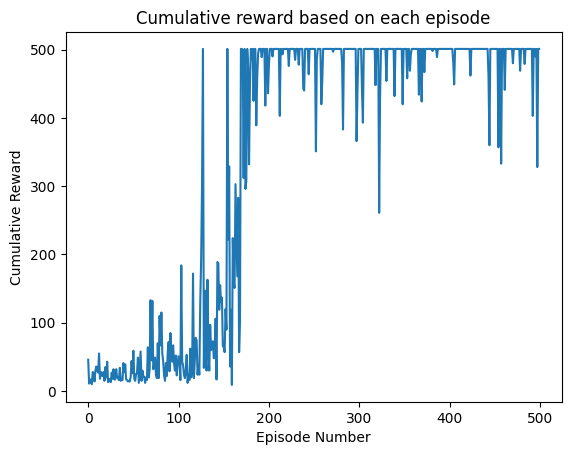

In [19]:
plt.plot(R_table)
plt.title('Cumulative reward based on each episode')
plt.ylabel('Cumulative Reward')
plt.xlabel('Episode Number')
plt.show()

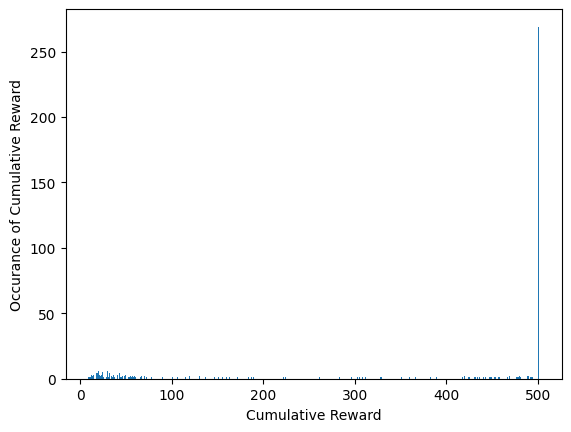

In [20]:
from collections import Counter

plt.bar(Counter(R_table).keys(), Counter(R_table).values())
plt.xlabel('Cumulative Reward')
plt.ylabel('Occurance of Cumulative Reward')
plt.show()

# TASK 2: EFFECTIVENESS OF RL AGENT

We'll evaluate the effectiveness of our RL agent on the CartPole environment. The agent will be tested for 100 episodes, and for each episode, the total reward it earns (keeping the pole balanced) will be tracked. A plot will be generated to visualize the agent's performance (cumulative reward) across all episodes. Additionally, the average reward over the 100 episodes will be calculated and printed. If the average reward is greater than 195, it suggests the agent has learned a successful strategy for balancing the pole. This test helps assess the agent's ability to perform consistently well in the environment. 

In [21]:
env = gym.make('CartPole-v1')

number_of_episodes = 100
cumulative_episodes_reward = []

for episode_count in tqdm(range(number_of_episodes)):
    current_state, _ = env.reset()
    total_rewards = []
    terminated = False
    
    while not terminated and np.sum(total_rewards) < 500:
        current_state_index = discretise_state(current_state)
        action = calculate_action(current_state_index, epsilon)
        next_state, reward, terminated, _, _ = env.step(action)
        total_rewards.append(reward)
        current_state = next_state

    cumulative_episodes_reward.append(np.sum(total_rewards))

env.close()

100%|██████████| 100/100 [00:04<00:00, 21.74it/s]


We then plot the cumulative reward against the different episodes. This shows beyond a doubt that our model is effective in balancing the CartPole

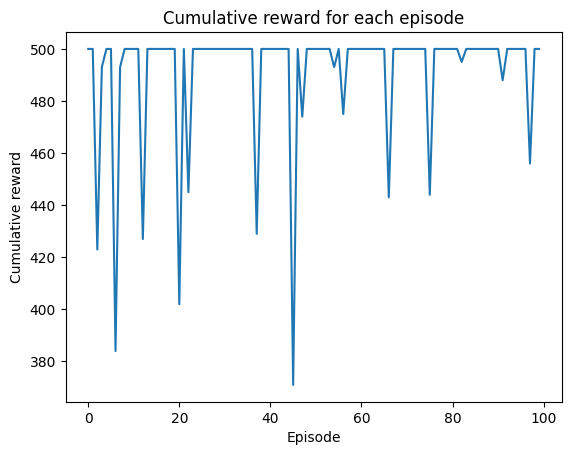

In [22]:

plt.plot(cumulative_episodes_reward)
plt.title('Cumulative reward for each episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative reward')
plt.show()

In [23]:
average_episodes_reward = np.mean(cumulative_episodes_reward)
print(f'Average cumulative reward: {average_episodes_reward}')
print(f"Is my agent good enough (>195 as per the question requirements?): {average_episodes_reward > 195}")

Average cumulative reward: 491.35
Is my agent good enough (>195 as per the question requirements?): True


# TASK 3: SIMULATE AN EPISODE OF THE RL AGENT

This task requires us to visulaise the agent's performance in the CartPole environment for a single episode. The next section shows an example episode played by the RL agent. 

Note: ensure FFmpeg is installed on your system \
For windows users(powershell): run winget install ffmpeg

In [24]:
def simulate_learned_strategy(q_matrix):
    env = gym.make("CartPole-v1", render_mode="rgb_array")  # replace with your environment
    env = RecordVideo(env, video_folder="./videos", name_prefix="eval", episode_trigger=lambda x: True)
    
    current_state, _ = env.reset()
    env.start_video_recorder()
    total_rewards = []
    terminated = False
    while not terminated:
        current_state_index = discretise_state(current_state)
        action = calculate_action(current_state_index, epsilon)
        next_state, reward, terminated, _, _ = env.step(action)
        total_rewards.append(reward)
        current_state = next_state
        time.sleep(0.05)

    time.sleep(1)
    env.close()
    env.close_video_recorder()
    return total_rewards

total_rewards = simulate_learned_strategy(Q_table)

c:\Users\Jovan\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at c:\Users\Jovan\Documents\repos\sc3000-project\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
c:\Users\Jovan\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_wrapper_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(


Moviepy - Building video c:\Users\Jovan\Documents\repos\sc3000-project\videos\eval-episode-0.mp4.
Moviepy - Writing video c:\Users\Jovan\Documents\repos\sc3000-project\videos\eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jovan\Documents\repos\sc3000-project\videos\eval-episode-0.mp4


Moviepy - Building video c:\Users\Jovan\Documents\repos\sc3000-project\videos\eval-episode-0.mp4.
Moviepy - Writing video c:\Users\Jovan\Documents\repos\sc3000-project\videos\eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jovan\Documents\repos\sc3000-project\videos\eval-episode-0.mp4


In [25]:
print(f"Episode Reward: {np.sum(total_rewards)}")
Video("videos/eval-episode-0.mp4")

Episode Reward: 560.0


# TASK 4: INSTRUCTION AND EXPLANATION

We have included detailed explanation and elaboration on the various functions and concepts discussed in this notebook

After hours of studying and ideating on the topic, we decided to go with the approach of implementing a learning and epsilon decay. We felt that analogous to how we humans learn, implementing such a feature made it ever more realistic. 

Regarding the epsilon decay, the logic goes as such. When thrown into an unknown environment, it is one's first instinct to explore and know as much as you can about it. This means trying new things and going on new paths that have not been ventured before. This is done at the expense of reinforcing what you originally know and we personally felt that one's knowledge base at this point in time is not sufficient enough for that great of a drawback. However, as time progresses and one's knowledge base is growing, this drawback can get increasingly more significant. This is when the epsilon variable is decayed, so as to reduce exploration in favour of exploitation. Now equipped with a larger knowledge base, it is advantegous to make use of it in place of exploring new things. Having heard this concept many times during lectures, we are glad that we finally could implement it in real life. 

Learning decay is also another concept we came across. The learning rate is decayed in Q-learning for two key reasons. First, a decaying learning rate helps the agent converge to a stable solution by preventing overly large updates to Q-values later in training. This allows for finer adjustments and avoids the agent from oscillating or diverging. Second, it promotes a shift from exploration to exploitation. As the agent learns, smaller updates encourage it to prioritize actions with higher known Q-values, leading to more consistent and optimal performance. In essence, decaying the learning rate helps the agent find the best strategy while maintaining stability. 

With this two approaches, we succesfully implemented an effective RL agent for the CartPole environment